In [346]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from torch.optim import SGD

import numpy as np
from numpy import dot
import matplotlib.pyplot as plt

In [347]:
input_size = 784
hidden_size = 2048
num_classes = 10
num_epochs = 50
batch_size = 100
learning_rate = 0.01

S_G=5
M_train=2000

In [348]:
# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='data', 
                                           train=True, 
                                           transform=transforms.ToTensor(), 
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='data', 
                                          train=False, 
                                          transform=transforms.ToTensor())


train_subset_index=list(range(M_train))

train_subset_dataset=Subset(train_dataset, train_subset_index)


# Data loader
train_loader = DataLoader(dataset=train_subset_dataset, batch_size=batch_size, shuffle=True)

test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

train_loader_1=DataLoader(dataset=train_subset_dataset, batch_size=1)

In [349]:
labels_to_investigate=[0,4,9]

In [350]:
import copy

labels_tofill=labels_to_investigate.copy()
labels_freq=[0 for k in range(len(labels_tofill))]
G_ind_tr=[]
for k,(image, label) in enumerate(train_loader_1):
    label=label.tolist()[0]
    if label in labels_tofill:
        ix=labels_to_investigate.index(label)
        G_ind_tr.append(k)
        labels_freq[ix]+=1
        if labels_freq[ix]==S_G:
            labels_tofill.remove(label)
    if len(labels_tofill)==0:
        break

labels_tofill=labels_to_investigate.copy()
labels_freq=[0 for k in range(len(labels_tofill))]
G_ind_ts=[]
for k,(image, label) in enumerate(train_loader_1):
    label=label.tolist()[0]
    if label in labels_tofill:
        ix=labels_to_investigate.index(label)
        G_ind_ts.append(k)
        labels_freq[ix]+=1
        if labels_freq[ix]==S_G:
            labels_tofill.remove(label)
    if len(labels_tofill)==0:
        break

G_subset_tr=Subset(train_dataset, G_ind_tr)
G_subset_ts=Subset(test_dataset, G_ind_ts)

G_loader_tr = DataLoader(dataset=G_subset_tr, batch_size=1, shuffle=False)
G_loader_ts = DataLoader(dataset=G_subset_ts, batch_size=1, shuffle=False)

In [351]:
# Fully connected neural network
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_size) 
        self.output_layer = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        x = self.input_layer(x)
        x = x.relu()
        x = self.output_layer(x)
        return x
    
def ReLU_glorot_init(model):
    for name, param in model.named_parameters():
        
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            nn.init.xavier_normal_(param)

In [352]:
# Train the model

model = NeuralNet(input_size, hidden_size, num_classes)
ReLU_glorot_init(model)

init_grads_tr=[]
init_grads_ts=[]

criterion = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=learning_rate)


for image,label in G_loader_tr:
    image = image.reshape(-1, 28*28)
    output=model(image)
    loss = criterion(output,label)
    loss.backward()
    init_grad=[]
    init_grad+=torch.flatten(model.input_layer.weight.grad).tolist()
    init_grad+=model.input_layer.bias.grad.tolist()
    init_grad+=torch.flatten(model.output_layer.weight.grad).tolist()
    init_grad+=model.output_layer.bias.grad.tolist()
    init_grad=np.array(init_grad)
    init_grad=init_grad/np.linalg.norm(init_grad)
    init_grads_tr.append(init_grad)

for image,label in G_loader_ts:
    image = image.reshape(-1, 28*28)
    output=model(image)
    loss = criterion(output,label)
    loss.backward()
    init_grad=[]
    init_grad+=torch.flatten(model.input_layer.weight.grad).tolist()
    init_grad+=model.input_layer.bias.grad.tolist()
    init_grad+=torch.flatten(model.output_layer.weight.grad).tolist()
    init_grad+=model.output_layer.bias.grad.tolist()
    init_grad=np.array(init_grad)
    init_grad=init_grad/np.linalg.norm(init_grad)
    init_grads_ts.append(init_grad)

def train_epoch(GETGRADIENTS=False):
    for images, labels in train_loader:
        images = images.reshape(-1, 28*28)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    r_loss=loss.item()
    if GETGRADIENTS:
        dots_tr=[]
        for k,(image, label) in enumerate(G_loader_tr):
            image = image.reshape(-1, 28*28)
            output=model(image)
            loss = criterion(output,label)
            loss.backward()
            gradient=[]
            gradient+=torch.flatten(model.input_layer.weight.grad).tolist()
            gradient+=model.input_layer.bias.grad.tolist()
            gradient+=torch.flatten(model.output_layer.weight.grad).tolist()
            gradient+=model.output_layer.bias.grad.tolist()
            gradient=np.array(gradient)
            gradient=gradient/np.linalg.norm(gradient)
            dots_tr.append(np.dot(init_grads_tr[k],gradient))
        dots_ts=[]
        for k,(image, label) in enumerate(G_loader_ts):
            image = image.reshape(-1, 28*28)
            output=model(image)
            loss = criterion(output,label)
            loss.backward()
            gradient=[]
            gradient+=torch.flatten(model.input_layer.weight.grad).tolist()
            gradient+=model.input_layer.bias.grad.tolist()
            gradient+=torch.flatten(model.output_layer.weight.grad).tolist()
            gradient+=model.output_layer.bias.grad.tolist()
            gradient=np.array(gradient)
            gradient=gradient/np.linalg.norm(gradient)
            dots_ts.append(np.dot(init_grads_ts[k],gradient))

        return r_loss, dots_tr,dots_ts
    else:
        return loss.item()
    
def get_densities(train_dots,test_dots):
    from scipy.stats import gaussian_kde

    x_tr=np.linspace(min(0,min(train_dots)-0.05),max(max(train_dots)*1.05,1),100)
    x_ts=np.linspace(min(0,min(test_dots)-0.05),max(max(test_dots)*1.05,1),100)

    tr_densities=[]
    for n in range(len(labels_to_investigate)):
        tr_densities.append(gaussian_kde(train_dots[n*S_G:(n+1)*S_G])(x_tr))

    ts_densities=[]
    for n in range(len(labels_to_investigate)):
        ts_densities.append(gaussian_kde(test_dots[n*S_G:(n+1)*S_G])(x_ts))
        
    return tr_densities,ts_densities,x_tr,x_ts

train_loss = []
dots_tr = []
dots_ts = []
dots_den_tr=[]
den_x_tr=[]
dots_den_ts=[]
den_x_ts=[]
epoch_list=[]

for epoch in range(num_epochs):
    if (epoch+1)%2==0:
        trainloss, ds_tr,ds_ts = train_epoch(GETGRADIENTS=True)
        train_loss.append(trainloss)
        dots_tr.append(ds_tr)
        dots_ts.append(ds_ts)
        epoch_list.append(epoch+1)
    if (epoch+1)%10==0:
        tr,ts,tr_x,ts_x=get_densities(dots_tr[-1],dots_ts[-1])
        dots_den_tr.append(tr)
        dots_den_ts.append(ts)
        den_x_tr.append(tr_x)
        den_x_ts.append(ts_x)
    else:
        trainloss=train_epoch()
    print('Epoch: {} TrainLoss: {:.3f}'.format(epoch+1,trainloss))

Epoch: 1 TrainLoss: 2.074
Epoch: 2 TrainLoss: 1.630
Epoch: 3 TrainLoss: 1.469
Epoch: 4 TrainLoss: 1.252
Epoch: 5 TrainLoss: 1.094
Epoch: 6 TrainLoss: 0.980
Epoch: 7 TrainLoss: 0.873
Epoch: 8 TrainLoss: 0.844
Epoch: 9 TrainLoss: 0.663
Epoch: 10 TrainLoss: 0.756
Epoch: 11 TrainLoss: 0.712
Epoch: 12 TrainLoss: 0.708
Epoch: 13 TrainLoss: 0.687
Epoch: 14 TrainLoss: 0.439
Epoch: 15 TrainLoss: 0.467
Epoch: 16 TrainLoss: 0.476
Epoch: 17 TrainLoss: 0.482
Epoch: 18 TrainLoss: 0.531
Epoch: 19 TrainLoss: 0.443
Epoch: 20 TrainLoss: 0.476
Epoch: 21 TrainLoss: 0.464
Epoch: 22 TrainLoss: 0.461
Epoch: 23 TrainLoss: 0.560
Epoch: 24 TrainLoss: 0.429
Epoch: 25 TrainLoss: 0.360
Epoch: 26 TrainLoss: 0.415
Epoch: 27 TrainLoss: 0.359
Epoch: 28 TrainLoss: 0.314
Epoch: 29 TrainLoss: 0.461
Epoch: 30 TrainLoss: 0.475
Epoch: 31 TrainLoss: 0.418
Epoch: 32 TrainLoss: 0.556
Epoch: 33 TrainLoss: 0.418
Epoch: 34 TrainLoss: 0.301
Epoch: 35 TrainLoss: 0.362
Epoch: 36 TrainLoss: 0.322
Epoch: 37 TrainLoss: 0.335
Epoch: 38 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


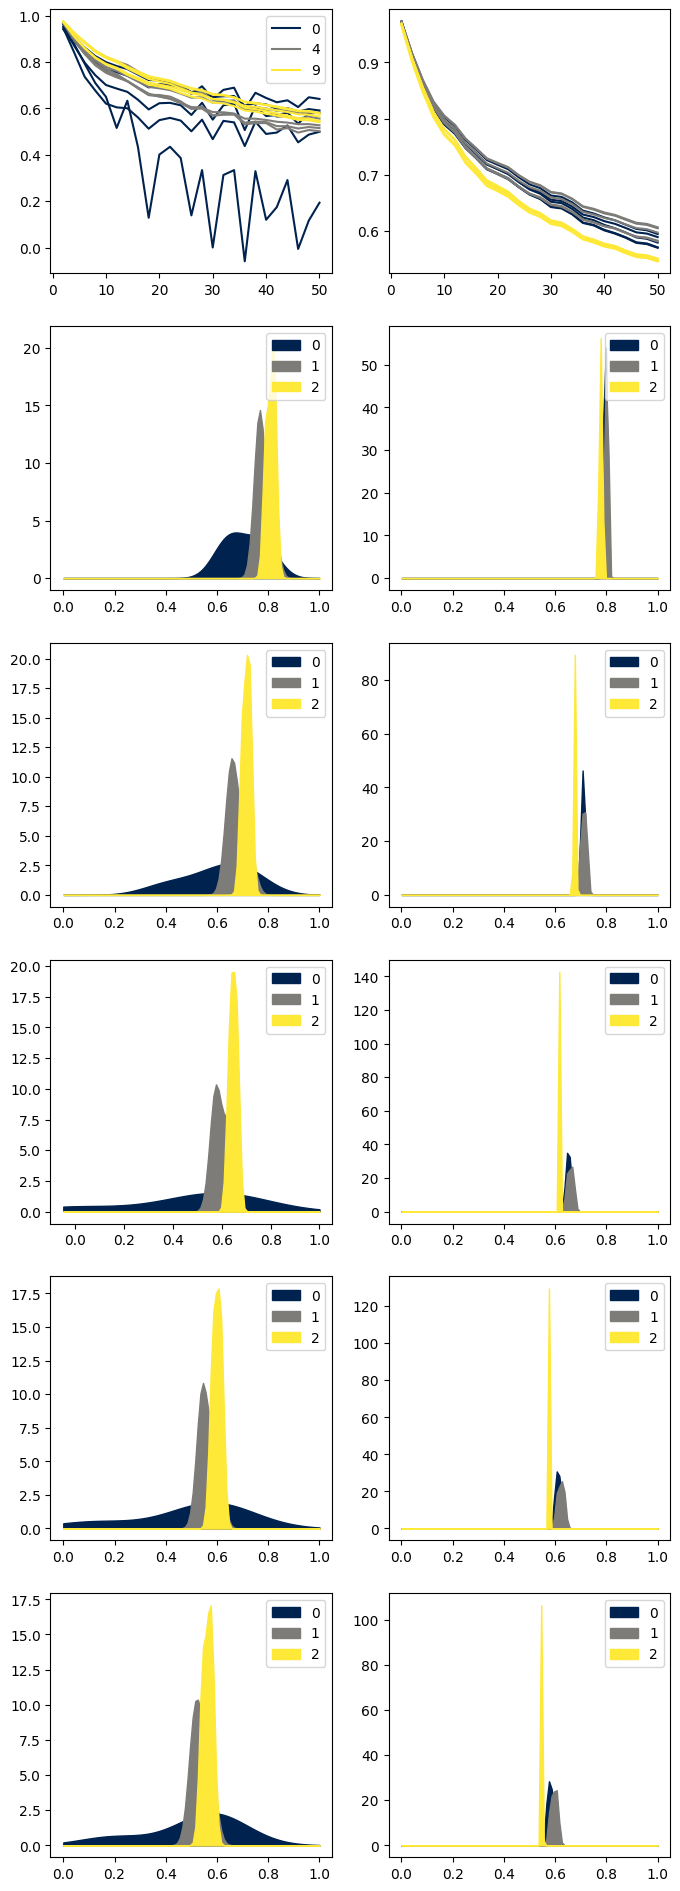

In [353]:
N=len(epoch_list)

colors = plt.cm.cividis(np.linspace(0, 1, len(labels_to_investigate)))

fig,axs=plt.subplots(len(dots_den_tr)+1,2,figsize=(8,4*(len(dots_den_tr)+1)))

for i in range(len(labels_to_investigate)):
    for j in range(S_G):
        if j==0:
            axs[0,0].plot(epoch_list,[dots_tr[n][i*S_G+j] for n in range(N)], c=colors[i],label=str(labels_to_investigate[i]))
            axs[0,1].plot(epoch_list,[dots_ts[n][i*S_G+j] for n in range(N)], c=colors[i],label=str(labels_to_investigate[i]))
        else:
            axs[0,0].plot(epoch_list,[dots_tr[n][i*S_G+j] for n in range(N)], c=colors[i])
            axs[0,1].plot(epoch_list,[dots_ts[n][i*S_G+j] for n in range(N)], c=colors[i])
axs[0,0].legend()
axs[1,1].legend()

for i,dens in enumerate(dots_den_tr):
    for j,den in enumerate(dens):
        axs[i+1,0].fill_between(den_x_tr[i],den,color=colors[j],label=str(j))
    axs[i+1,0].legend()

for i,dens in enumerate(dots_den_ts):
    for j,den in enumerate(dens):
        axs[i+1,1].fill_between(den_x_ts[i],den,color=colors[j],label=str(j))
    axs[i+1,1].legend()

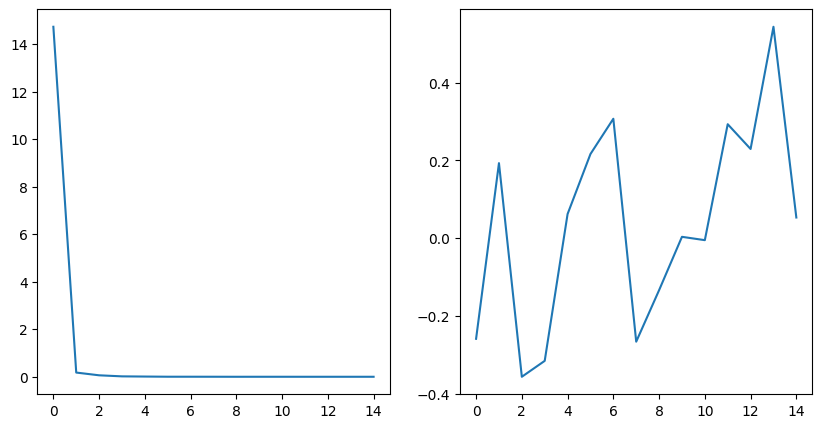

In [354]:
grad_matrix=[]
for image,label in G_loader_ts:
        image = image.reshape(-1, 28*28)
        output=model(image)
        loss = criterion(output,label)
        loss.backward()
        gradient=[]
        gradient+=torch.flatten(model.input_layer.weight.grad).tolist()
        gradient+=model.input_layer.bias.grad.tolist()
        gradient+=torch.flatten(model.output_layer.weight.grad).tolist()
        gradient+=model.output_layer.bias.grad.tolist()
        gradient=np.array(gradient)
        gradient=gradient/np.linalg.norm(gradient)
        grad_matrix.append(gradient)

ker_matrix=[]
for vec1 in grad_matrix:
    row=[]
    for vec2 in grad_matrix:
          row.append(np.dot(vec1,vec2))
    ker_matrix.append(row)

evals,evectors=np.linalg.eig(ker_matrix)

fig,axs=plt.subplots(1,2,figsize=(10,5))

axs[0].plot(np.arange(len(evals)),evals)

axs[1].plot(np.arange(len(evectors[0])),evectors[0])